## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

In [50]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
flights = pd.read_csv('G_PSQL_data/sample_final.csv', low_memory = False)
passengers = pd.read_csv('G_PSQL_data/passenger_sample.txt')
fuel = pd.read_csv('G_PSQL_data/fuel_consumption.csv')

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

In [3]:
flights1 = flights.copy(deep=True)

In [4]:
flights1['arr_delay'].isnull().sum()

47107

In [5]:
flights1 = flights1[flights1['arr_delay'].notnull()]

In [6]:
flights1 = flights1[flights1['arr_delay'] < 400]

/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


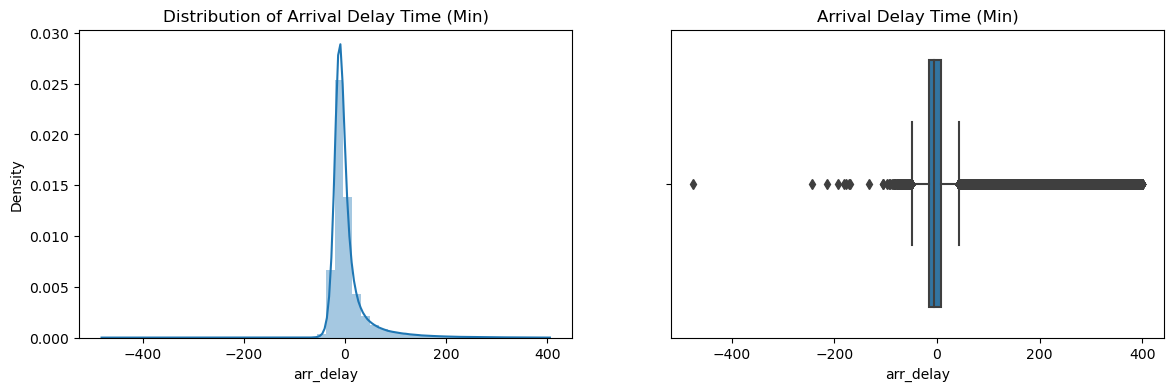

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sn.distplot(flights1['arr_delay'], ax=ax[0])
sn.boxplot(flights1['arr_delay'], ax=ax[1])

ax[0].set_title('Distribution of Arrival Delay Time (Min)')
ax[1].set_title('Arrival Delay Time (Min)');               
plt.show()

In [8]:
flights1['arr_delay'].describe()

count    2.335888e+06
mean     4.211975e+00
std      3.903707e+01
min     -4.750000e+02
25%     -1.500000e+01
50%     -6.000000e+00
75%      8.000000e+00
max      3.990000e+02
Name: arr_delay, dtype: float64

In [9]:
#need to remove outliers greater than 3 std

# calculate summary statistics
data_mean, data_std = np.mean(flights1['arr_delay']), np.std(flights1['arr_delay'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in flights1['arr_delay'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers

flights1['arr_delay'].drop(flights1[(flights1['arr_delay'] > upper) | (flights1['arr_delay'] < lower)].index, inplace=True)




Identified outliers: 55466


In [10]:
flights1['arr_delay'].describe()

count    2.280422e+06
mean    -2.521976e-01
std      2.511122e+01
min     -1.060000e+02
25%     -1.500000e+01
50%     -7.000000e+00
75%      6.000000e+00
max      1.210000e+02
Name: arr_delay, dtype: float64

In [11]:
st.normaltest(flights1['arr_delay'])

NormaltestResult(statistic=901187.3066914338, pvalue=0.0)

In [12]:
st.ttest_1samp(flights1['arr_delay'], 0)

Ttest_1sampResult(statistic=-15.166338845550799, pvalue=5.9428395206104215e-52)

p_value is smaller than 0.05, reject null hypothesis of normal distribution.

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [13]:
flights2 = flights.copy(deep=True)

In [14]:

flights2['fl_date'] = pd.to_datetime(flights2['fl_date'])
flights2['fl_month'] = flights2['fl_date'].dt.month

av_delay = flights2[['fl_month','arr_delay']].groupby('fl_month').agg('mean')
av_delay.reset_index(inplace=True)
av_delay.sort_values('arr_delay', ascending=False)

,fl_month,arr_delay
5,6,10.094615
6,7,8.904272
7,8,8.774367
1,2,6.644681
4,5,6.617094
11,12,4.990300
3,4,4.232403
0,1,3.965351
10,11,3.054911
2,3,2.888558


In [15]:
pd.read_csv('G_PSQL_data/median by month.txt') 

,percentile_cont,date_part
0,-7,1
1,-6,2
2,-7,3
3,-7,4
4,-6,5
5,-4,6
6,-5,7
7,-5,8
8,-8,9
9,-7,10


### Yes, what could be the reason? 

maybe we could count number of flights for each month (more flights = more delays) 

In [17]:
flights2['fl_date'] = pd.to_datetime(flights2['fl_date'])
flights2['month'] = flights2['fl_date'].dt.month



In [18]:
flight_count = flights2[['month','mkt_carrier_fl_num']].groupby('month').agg({'mkt_carrier_fl_num':'count'})
flight_count.reset_index(inplace=True)
flight_count.rename(columns={'mkt_carrier_fl_num':'total_flights'}, inplace=True)
flight_count

,month,total_flights
0,1,186503
1,2,172504
2,3,203132
3,4,197197
4,5,204896
5,6,206468
6,7,212514
7,8,212463
8,9,195092
9,10,204612


In [19]:
delay_vs_flightcount = av_delay.merge(flight_count, how='left', left_on='fl_month', right_on='month')

delay_vs_flightcount

,fl_month,arr_delay,month,total_flights
0,1,3.965351,1,186503
1,2,6.644681,2,172504
2,3,2.888558,3,203132
3,4,4.232403,4,197197
4,5,6.617094,5,204896
5,6,10.094615,6,206468
6,7,8.904272,7,212514
7,8,8.774367,8,212463
8,9,1.653328,9,195092
9,10,2.826872,10,204612


In [20]:
table = pd.pivot_table(delay_vs_flightcount,index=["month","total_flights"], values = ['arr_delay'])
table = table.reset_index(level=["month","total_flights"])
table

,month,total_flights,arr_delay
0,1,186503,3.965351
1,2,172504,6.644681
2,3,203132,2.888558
3,4,197197,4.232403
4,5,204896,6.617094
5,6,206468,10.094615
6,7,212514,8.904272
7,8,212463,8.774367
8,9,195092,1.653328
9,10,204612,2.826872


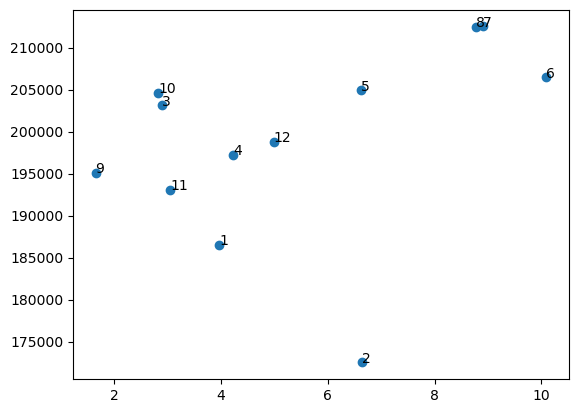

In [21]:
x = table['total_flights']
y = table['arr_delay']
n = table['month']

plt.scatter(y,x)

#fig, ax = plt.subplots()

for i, txt in enumerate(n):
    plt.annotate(txt, (y[i], x[i]))

plt.show()

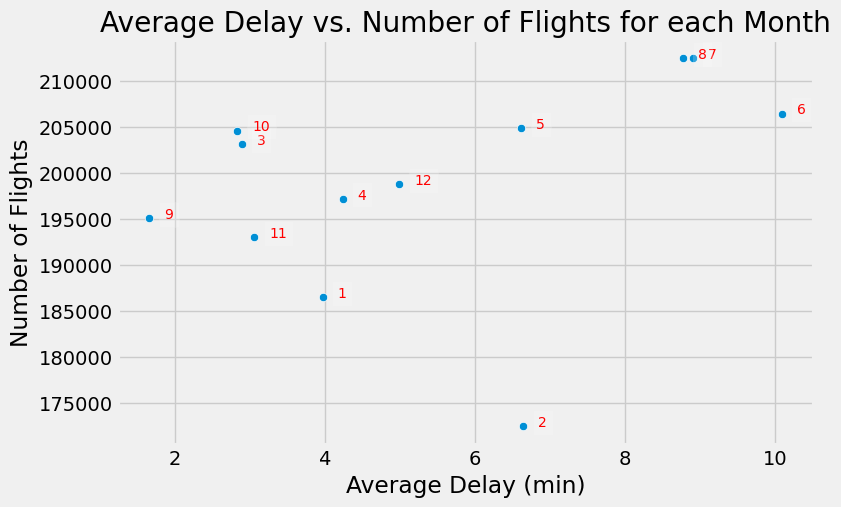

In [125]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=table,x='arr_delay',y='total_flights')

for i in range(table.shape[0]):
    plt.text(x=table.arr_delay[i]+0.2,y=table.total_flights[i]+0.3,s=table.month[i], 
          fontdict=dict(color='red',size=10),
          bbox=dict(facecolor='white',alpha=0.2))


plt.title('Average Delay vs. Number of Flights for each Month') #title
plt.xlabel('Average Delay (min)') #x label
plt.ylabel('Number of Flights') #y label

plt.show()

There appears to be a correlation between month and average delay. Will rank and export as csv for modelling. 

In [ ]:
table.to_csv("G_PSQL_data/month_delay.csv")

#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

In [22]:
flights3 = flights.copy(deep=True)

small sample from chicago airport (most variable weather)

In [23]:
chicago = flights3.loc[flights3.origin_city_name == "Chicago, IL"]


In [24]:
weather = pd.read_csv("G_PSQL_data/Chicago_Weather.csv")


In [25]:
c_w = chicago.merge(weather, how='left', left_on="fl_date", right_on='datetime')

In [26]:
c_w.conditions.unique()

array([nan, 'Snow, Overcast', 'Snow, Partially cloudy', 'Clear',
       'Partially cloudy', 'Rain, Partially cloudy', 'Overcast',
       'Rain, Overcast'], dtype=object)

In [27]:
c_w.replace({'Partially cloudy': 'Cloudy',
                           'Overcast': 'Cloudy',
                           'Snow, Overcast': 'Snow',
                           'Rain, Overcast': 'Rain',
                          'Snow, Partially cloudy': 'Snow',
                          'Rain, Partially cloudy': 'Rain'}, inplace=True)




In [28]:
c_w

,Unnamed: 0,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,...,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,datetime,conditions
0,31,2019-12-29,NK,NK,NK,968,NK,N919NK,968,13930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57,2019-12-29,AA,AA,AA,1156,AA,N915AN,1156,13930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61,2019-12-29,AA,AA,AA,1172,AA,N943AN,1172,13930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,62,2019-12-29,AA,AA,AA,1173,AA,N768US,1173,13930,...,0.0,19.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,72,2019-12-29,AA,AA,AA,1211,AA,N801NN,1211,13930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144897,2387137,2019-12-29,AA,AA_CODESHARE,AA,4181,MQ,N675AE,4181,13930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144898,2387138,2019-12-29,AA,AA_CODESHARE,AA,4188,MQ,N935AE,4188,13930,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
144899,2387147,2019-12-29,AA,AA_CODESHARE,AA,4248,MQ,N273NN,4248,13930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144900,2387149,2019-12-29,AA,AA_CODESHARE,AA,4217,MQ,N606AE,4217,13930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
c_w.drop(columns=["fl_date","origin_city_name","datetime"], inplace=True)

In [30]:
c_w = c_w[c_w['dep_delay'] < 400]

In [31]:
#need to remove outliers greater than 3 std

# calculate summary statistics
data_mean, data_std = np.mean(c_w['dep_delay']), np.std(c_w['dep_delay'])
# identify outliers
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
# identify outliers
outliers = [x for x in c_w['dep_delay'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
# remove outliers

c_w['dep_delay'].drop(c_w[(c_w['dep_delay'] > upper) | (c_w['dep_delay'] < lower)].index, inplace=True)




Identified outliers: 3594


/Users/admin/opt/anaconda3/envs/lighthouse_labs/lib/python3.8/site-packages/pandas/core/generic.py:3939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


In [32]:
import seaborn as sn
from matplotlib import pyplot as plt

In [33]:
clear = c_w.loc[c_w['conditions'] == 'Clear', ['dep_delay']]


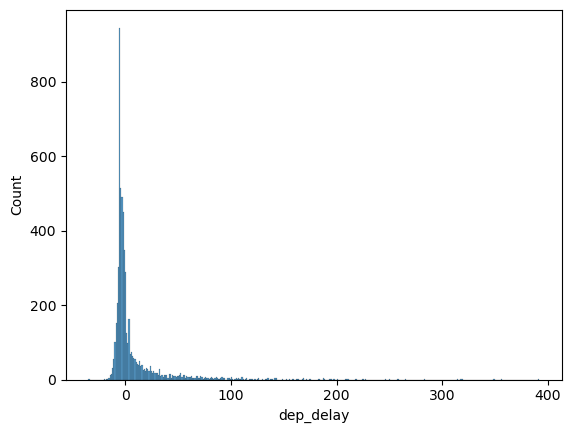

In [34]:
sn.histplot(clear["dep_delay"])
plt.show()


In [35]:
clear['dep_delay'].describe()

count    5760.000000
mean        6.915799
std        29.660855
min       -35.000000
25%        -5.000000
50%        -2.000000
75%         5.000000
max       392.000000
Name: dep_delay, dtype: float64

In [36]:
cloudy = c_w.loc[c_w['conditions'] == 'Cloudy', ['dep_delay']]

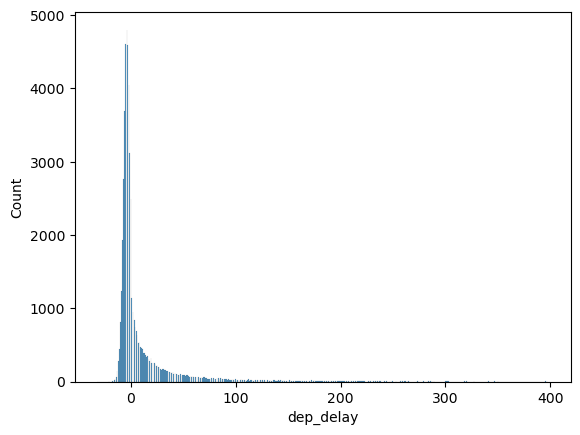

In [ ]:
sn.histplot(cloudy["dep_delay"])
plt.show()


In [ ]:
cloudy['dep_delay'].describe()

count    53899.000000
mean         8.836361
std         31.939534
min        -32.000000
25%         -5.000000
50%         -2.000000
75%          7.000000
max        398.000000
Name: dep_delay, dtype: float64

In [ ]:
rain = c_w.loc[c_w['conditions'] == 'Rain', ['dep_delay']]

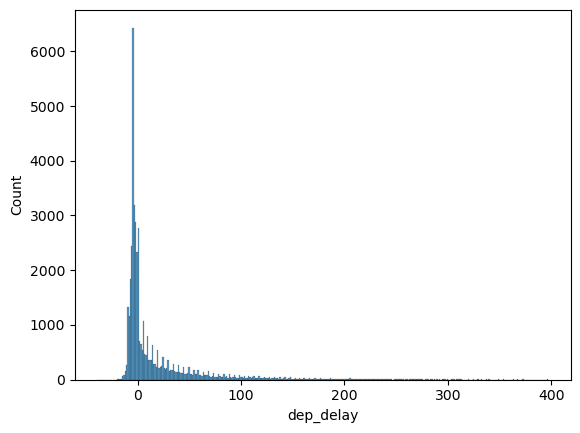

In [ ]:
sn.histplot(rain["dep_delay"])
plt.show()


In [ ]:
rain['dep_delay'].describe()

count    42915.000000
mean        17.115507
std         43.654736
min        -39.000000
25%         -4.000000
50%         -1.000000
75%         18.000000
max        397.000000
Name: dep_delay, dtype: float64

In [ ]:
snow = c_w.loc[c_w['conditions'] == 'Snow', ['dep_delay']]

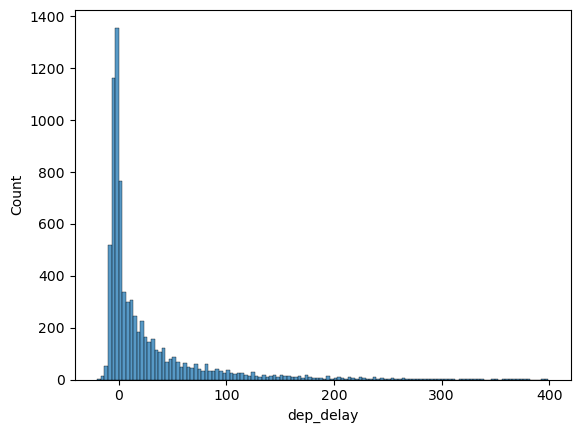

In [ ]:
sn.histplot(snow["dep_delay"])
plt.show()


In [ ]:
snow['dep_delay'].describe()

count    7763.000000
mean       25.139508
std        51.790893
min       -20.000000
25%        -3.000000
50%         4.000000
75%        30.000000
max       399.000000
Name: dep_delay, dtype: float64

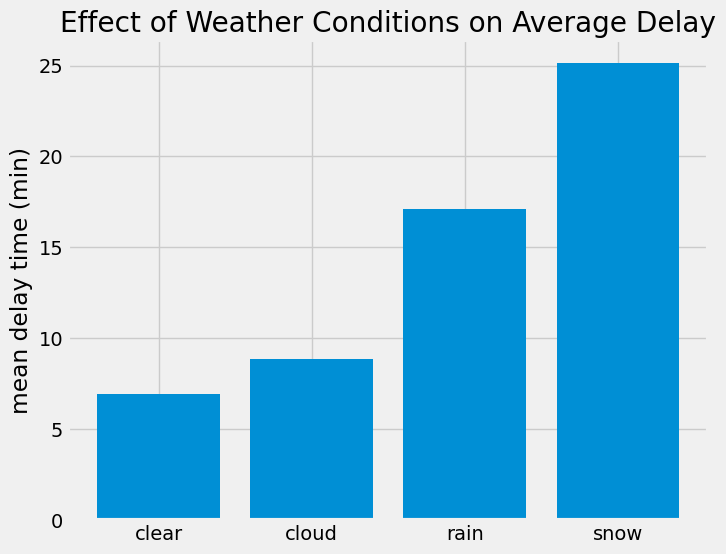

In [122]:
a = np.mean(clear['dep_delay'])
c = np.mean(cloudy['dep_delay'])
b = np.mean(rain['dep_delay'])
d = np.mean(snow['dep_delay'])

conditions = ['clear','cloud','rain','snow']
average_weather_del = [a,c,b,d]
plt.style.use('fivethirtyeight') 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(conditions,average_weather_del)
ax.set_ylabel('mean delay time (min)')
ax.set_title('Effect of Weather Conditions on Average Delay')
plt.show()

There is an obvious difference in delay. I will rank conditions by length of delay. (refer to db creator) 

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [66]:
flights4 = flights.copy(deep=True)

In [67]:
flights4.drop(columns=['first_dep_time', 'distance', 'flights', 'air_time', 'actual_elapsed_time', 'dup', 'diverted', 'cancellation_code', 'cancelled', 'origin_city_name', 'dest_city_name'], inplace=True)

In [82]:
flights3['arr_time'] = pd.to_datetime(flights3['arr_time'], format='%H%M', errors='coerce')

In [83]:
flights3['dep_time'] = pd.to_datetime(flights3['dep_time'], format='%Y%H%M', errors='coerce')

In [84]:
flights4['dep_time'] = flights3[(flights3['dep_time'].dt.hour >= 6) | (flights3['dep_time'].dt.hour <= 11)]

In [85]:
times = flights3.groupby(flights3['dep_time'])['dep_time', 'taxi_in'].mean().reset_index()

<ipython-input-85-990fb0ccb96b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  times = flights3.groupby(flights3['dep_time'])['dep_time', 'taxi_in'].mean().reset_index()


In [86]:
temp = flights3.groupby(flights3['arr_time'].dt.hour)['arr_time', 'taxi_out'].mean().reset_index()

<ipython-input-86-fda35c863a05>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = flights3.groupby(flights3['arr_time'].dt.hour)['arr_time', 'taxi_out'].mean().reset_index()


In [87]:
times.rename(columns={'dep_time': 'time'}

In [88]:
taxi_times = temp.merge(times, left_on='arr_time', right_on='time')
taxi_times

,arr_time,taxi_out,time,taxi_in


#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?

In [ ]:
flights5 = flights.copy(deep=True)

In [ ]:
arrdelay = flights5[flights5['arr_delay'] > 0]

In [ ]:
ards = len(flights5['arr_delay'])

In [ ]:
depds = len(flights5[(flights5['dep_delay'] > 0)])

In [ ]:
(depds / ards) * 100

In [ ]:
arrdelay.drop(columns=['arr_time', 'dep_time'], inplace=True)

In [ ]:
arrdelay[['arr_delay', 'dep_delay']][arrdelay['arr_delay'] < arrdelay['dep_delay']]

#### **Task 6**: How many states cover 50% of US air traffic? 

In [90]:
flights6 = flights.copy(deep=True)

In [91]:
len(flights6)

2387175

In [92]:
len(set(flights6['origin']))

376

In [93]:
flights6['origin_states'] = flights6['origin_city_name'].str[-2:]

In [94]:
flights6['dest_states'] = flights6['dest_city_name'].str[-2:]

In [95]:
state_size = flights6.groupby(['origin_states', 'dest_states']).size().reset_index().groupby('origin_states').sum().reset_index().sort_values(by=0, ascending=False)

In [96]:
state_size.mean()

0    45041.037736
dtype: float64

In [97]:
state_size.reset_index(drop=True, inplace=True)

In [98]:
state_size['cumsum'] = state_size[0].cumsum()

In [100]:
state_size[state_size['cumsum'] < (len(flights6) / 2)]

,origin_states,0,cumsum
0,CA,260564,260564
1,TX,235075,495639
2,FL,172267,667906
3,IL,151951,819857
4,GA,125992,945849
5,NY,124150,1069999
6,NC,110182,1180181


#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

In [151]:
flights6 = flights.copy(deep=True)

In [152]:
flights6['miles_per_min'] = flights6['distance'] / flights6['actual_elapsed_time']

In [153]:
delayed = flights6[flights6['dep_delay'] > 0]['miles_per_min']

In [154]:
early = flights6[flights6['dep_delay'] <= 0]['miles_per_min']

In [159]:
delayed.describe()

count    796119.000000
mean          5.366308
std           1.540967
min           0.368889
25%           4.336634
50%           5.523810
75%           6.505525
max          10.308333
Name: miles_per_min, dtype: float64

In [160]:
early.describe()

count    1.543647e+06
mean     5.171522e+00
std      1.522500e+00
min      3.806818e-01
25%      4.119236e+00
50%      5.290323e+00
75%      6.299320e+00
max      1.069608e+01
Name: miles_per_min, dtype: float64

In [ ]:
st.ttest_ind(delayed.dropna(), early.dropna(), alternative='greater')

YES without a doubt planes delayed fly faster

#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

In [101]:
flights8 = flights.copy(deep=True)

In [102]:
flights8['dep_time'] = flights8['dep_time'].round(60)

In [103]:
flights8['dist_cats'] = pd.qcut(flights8['distance'], 3, labels=['short', 'medium', 'long'])

In [104]:
flights8['dep_time'] = pd.to_datetime(flights8['dep_time'], format='%H%M', errors='coerce') 

In [105]:
flights8['hour'] = flights8['dep_time'].dt.hour

In [106]:
s = flights8.groupby(['hour', 'dist_cats']).size().reset_index()

In [107]:
s.sort_values(0, ascending=False).groupby('dist_cats').head(3)

,hour,dist_cats,0
20,7.0,long,56186
17,6.0,long,54531
23,8.0,long,52862
48,17.0,short,50347
34,12.0,medium,49322
31,11.0,medium,49070
16,6.0,medium,48748
42,15.0,short,48562
33,12.0,short,47935


In [146]:
s = s.rename(columns={'name':'flight count','dist_cats':'Haul Length'})

In [147]:
s

,hour,Haul Length,flight count
0,1.0,short,343
1,1.0,medium,266
2,1.0,long,1043
3,2.0,short,336
4,2.0,medium,261
...,...,...,...
64,22.0,medium,20246
65,22.0,long,19130
66,23.0,short,7115
67,23.0,medium,4305


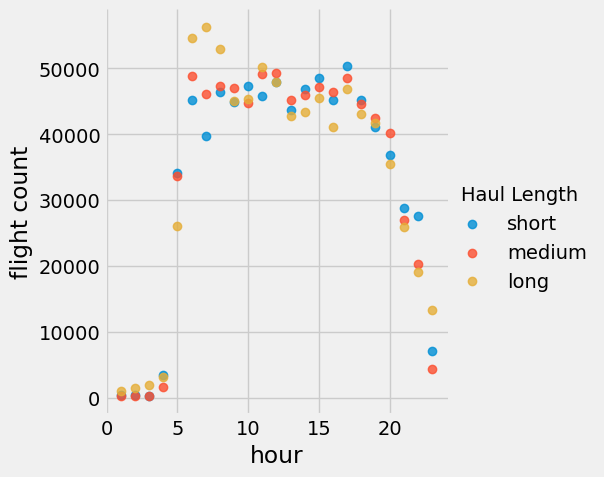

In [149]:
import seaborn as sns
sns.lmplot('hour', 'flight count', data=s, hue='Haul Length', fit_reg=False)

plt.show()

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [161]:
flights9 = flights.copy(deep=True)

In [162]:
dest = flights9[['dest','mkt_carrier_fl_num']].groupby('dest').agg({'mkt_carrier_fl_num':'count'})
dest.reset_index(inplace=True)
dest.rename(columns={'mkt_carrier_fl_num':'total_flights'}, inplace=True)

In [163]:
origin = flights9[['origin','mkt_carrier_fl_num']].groupby('origin').agg({'mkt_carrier_fl_num':'count'})
origin.reset_index(inplace=True)
origin.rename(columns={'mkt_carrier_fl_num':'total_flights'}, inplace=True)


In [164]:
airport_flights = dest.merge(origin, left_on='dest',right_on='origin')

In [165]:
airport_flights['total_flights'] = airport_flights['total_flights_x'] + airport_flights['total_flights_y']

In [166]:
airport_flights.to_csv('air_traffic.csv')

In [167]:
passengers = pd.read_csv('G_PSQL_data/passenger_sample.txt')

In [168]:
passeng = passengers.groupby(['origin', 'dest_airport_id'], as_index=False).sum().groupby('origin', as_index=False).agg({'passengers': 'sum'})

In [169]:
passeng = passeng.sort_values(by='passengers', ascending=False)

In [170]:
passeng

,origin,passengers
99,ATL,14984886
725,LAX,11816830
975,ORD,10908875
336,DFW,9582222
630,JFK,8760394
...,...,...
1214,SLU,0
284,COF,0
276,CN4,0
1205,SKJ,0


In [171]:
ftable = airport_flights.merge(passeng, left_on='origin', right_on='origin', how='inner')

In [180]:
ftable = ftable.sort_values(by="total_flights", ascending=False).reset_index(drop=False)

In [182]:
table = ftable.head(10)

In [183]:
table

,index,dest,total_flights_x,origin,total_flights_y,total_flights,passengers
0,257,ORD,118385,ORD,118961,237346,10908875
1,22,ATL,118102,ATL,117821,235923,14984886
2,95,DFW,87721,DFW,87153,174874,9582222
3,94,DEN,82823,DEN,82515,165338,8629178
4,74,CLT,75359,CLT,75003,150362,6900888
5,196,LAX,74841,LAX,75079,149920,11816830
6,321,SEA,57130,SEA,57046,114176,6387008
7,323,SFO,53645,SFO,53925,107570,7879311
8,272,PHX,53153,PHX,53302,106455,6398892
9,169,IAH,53160,IAH,53118,106278,6077053


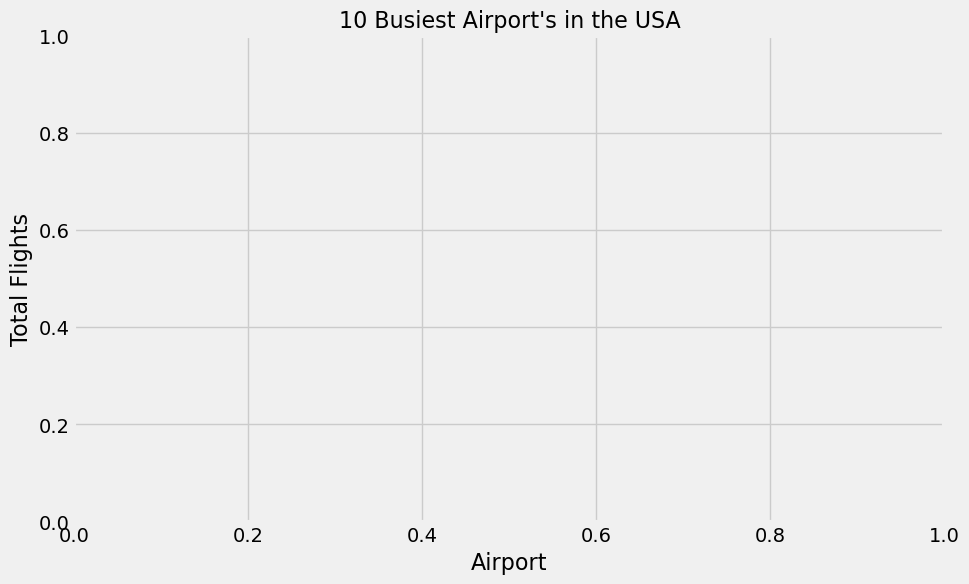

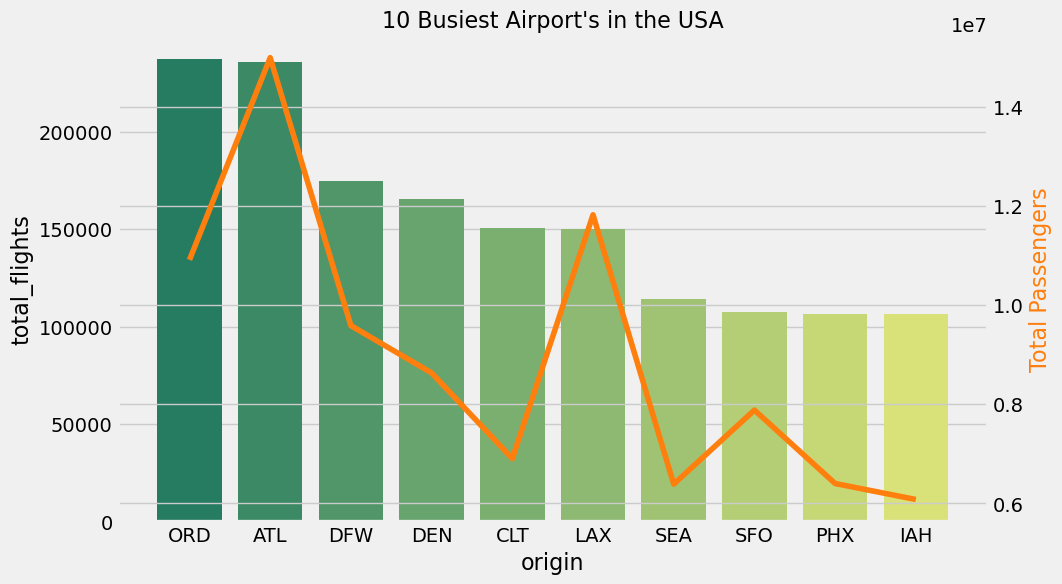

In [202]:

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('10 Busiest Airport\'s in the USA', fontsize=16)
ax1.set_xlabel('Airport', fontsize=16)
ax1.set_ylabel('Total Flights', fontsize=16)
ax2 = sns.barplot(x='origin', y='total_flights', data = table, palette='summer', color=color)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Total Passengers', fontsize=16, color=color)
ax2 = sns.lineplot(x='origin', y='passengers', data = table, sort=True, color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

In [201]:
ftable['flights/passengers'] = ftable['flights'] / ftable['passengers'] * 100

KeyError: 'flights'

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

In [ ]:
fuel = pd.read_csv('G_PSQL_data/fuel_consumption.csv')

In [4]:
fuel.head()

,Unnamed: 0,month,airline_id,unique_carrier,carrier,carrier_name,carrier_group_new,sdomt_gallons,satl_gallons,spac_gallons,...,sdomt_cost,satl_cost,spac_cost,slat_cost,sint_cost,ts_cost,tdomt_cost,tint_cost,total_cost,year
0,0,1,NaN,NaN,0JQ,NaN,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5100.0,0.0,5100.0,2016
1,1,1,21352.0,0WQ,0WQ,Avjet Corporation,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,396216.0,140239.0,536455.0,2016
2,2,1,21645.0,23Q,23Q,Songbird Airways Inc.,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
3,3,1,21652.0,27Q,27Q,"Jet Aviation Flight Services, Inc.",1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016
4,4,1,20408.0,5V,5V,Tatonduk Outfitters Limited d/b/a Everts Air A...,1,260848.0,0.0,0.0,...,522405.0,0.0,0.0,0.0,0.0,522405.0,569497.0,0.0,569497.0,2016


In [5]:
fuel.shape

(3035, 26)

In [30]:
#sum of delays/month per air carrier
m_delay = sample[['month','op_unique_carrier','arr_delay']].groupby(['month','op_unique_carrier']).sum().reset_index()
m_delay = m_delay[['op_unique_carrier','arr_delay']].groupby('op_unique_carrier').mean().reset_index()

m_delay

,op_unique_carrier,arr_delay
0,9E,569.750000
1,9K,-3.600000
2,AA,4729.833333
3,AS,56.750000
4,AX,972.916667
5,B6,3343.333333
6,C5,1200.083333
7,CP,226.250000
8,DL,-407.750000
9,EM,49.666667


In [34]:
# Find out distance covered monthly by different air carriers

c_dist = sample[['month','op_unique_carrier','distance']].groupby(['month','op_unique_carrier']).sum().reset_index()
c_dist = c_dist[['op_unique_carrier','distance']].groupby('op_unique_carrier').mean().reset_index()
#c_dist

c_dist

,op_unique_carrier,distance
0,9E,1.254804e+05
1,9K,2.434000e+02
2,AA,1.018801e+06
3,AS,3.676758e+05
4,AX,3.937667e+04
5,B6,3.581042e+05
6,C5,1.883317e+04
7,CP,5.623842e+04
8,DL,9.506340e+05
9,EM,6.163333e+02


In [2]:
passen = pd.read_csv('G_PSQL_data/passenger sample.txt')

NameError: name 'pd' is not defined

In [40]:
# Find out TOTAL number of passengers that were carried by different air carriers

c_p = passen[['month','unique_carrier','passengers']].groupby(['month','unique_carrier']).sum().reset_index()
c_p = c_p[['unique_carrier','passengers']].groupby('unique_carrier').mean().reset_index()


c_p

,unique_carrier,passengers
0,02Q,81.333333
1,04Q,925.181818
2,07Q,11.666667
3,09Q,15366.363636
4,0BQ,5.000000
...,...,...
348,Z3Q,1024.545455
349,ZE,2637.500000
350,ZK,1818.636364
351,ZW,126032.181818


In [41]:
carrier_fuel = fuel[['unique_carrier','tdomt_gallons']].groupby('unique_carrier').mean().reset_index()


In [43]:

avg = m_delay.merge(c_dist, left_on='op_unique_carrier', right_on='op_unique_carrier', how='outer')
avg = avg.merge(c_p, left_on='op_unique_carrier', right_on='unique_carrier', how='left')
avg = avg.merge(carrier_fuel, left_on='op_unique_carrier', right_on='unique_carrier', how='left')
avg.drop(columns=['unique_carrier_x','unique_carrier_y'],inplace=True)
avg = avg.fillna(0)
avg.head(1)

,op_unique_carrier,arr_delay,distance,passengers,tdomt_gallons
0,9E,569.75,125480.416667,313785.818182,0.0


In [1]:
avg['gal_p_km']=avg.tdomt_gallons / avg.passengers / avg.distance
avg.head()

NameError: name 'avg' is not defined

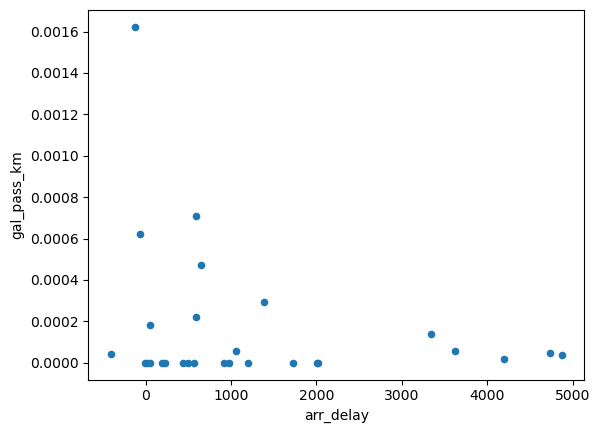

In [47]:
avg.plot(y='gal_pass_km', x='arr_delay', kind='scatter')
plt.show()

In [2]:
import pandas as pd

In [3]:
weather = pd.read_csv("weather_data.csv")